<a href="https://colab.research.google.com/github/JaperTai77/Tensorflow_DL/blob/main/tf2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning (Scaling up)

### Import data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

import zipfile
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

import tensorflow as tf
train10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              label_mode = 'categorical',
                                                              image_size = (224,224))
test = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                           label_mode = 'categorical',
                                                           image_size = (224,224),
                                                           shuffle = False)

## Train model with 10% data

### Original Model

#### Check point callback

In [3]:
path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(path,
                                                        save_weights_only = True,
                                                        monitor = 'val_accuracy',
                                                        save_best_only = True)


#### Build model

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
augmentation = tf.keras.models.Sequential([
               preprocessing.RandomFlip('horizontal'),
               preprocessing.RandomRotation(0.2),
               preprocessing.RandomHeight(0.2),
               preprocessing.RandomZoom(0.2),
               # preprocessing.Rescaling(1/255.)
])

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

input = tf.keras.layers.Input(shape = (224,224,3))
x = augmentation(input)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(train10.class_names), # len(train10.class_names)=101, 101 classes
                               activation="softmax", name="output_layer")(x)

model = tf.keras.Model(input, output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, None, 224, 3)      0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


#### Compile and fit model

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
history = model.fit(train10,epochs = 5, steps_per_epoch = len(train10),
                    validation_data = test,
                    validation_steps = int(0.15*len(test)),
                    callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 97s 259ms/step - loss: 3.4586 - accuracy: 0.2486 - val_loss: 2.7451 - val_accuracy: 0.3795
Epoch 2/5
237/237 [==============================] - 49s 206ms/step - loss: 2.3377 - accuracy: 0.4640 - val_loss: 2.2663 - val_accuracy: 0.4539
Epoch 3/5
237/237 [==============================] - 48s 203ms/step - loss: 1.9721 - accuracy: 0.5381 - val_loss: 2.1114 - val_accuracy: 0.4764
Epoch 4/5
237/237 [==============================] - 48s 202ms/step - loss: 1.7557 - accuracy: 0.5748 - val_loss: 2.0090 - val_accuracy: 0.4873
Epoch 5/5
237/237 [==============================] - 48s 200ms/step - loss: 1.6012 - accuracy: 0.6102 - val_loss: 1.9982 - val_accuracy: 0.4844


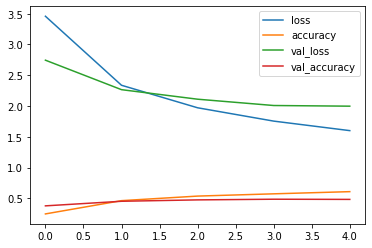

In [13]:
import pandas as pd
pd.DataFrame(history.history).plot()

**EVALUATION**

In [14]:
model.evaluate(test)

790/790 [==============================] - 102s 129ms/step - loss: 1.6889 - accuracy: 0.5592


[1.6888909339904785, 0.5592079162597656]

### Fine Tuned Model

In [17]:
base_model.trainable = True
for layers in base_model.layers[:-5]:
  layers.trainable = False

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])
print('What layers are trainable:')
for layer in model.layers:
  print(layer.name, layer.trainable)

What layers are trainable:
input_6 True
sequential_2 True
efficientnetb0 True
global_average_pooling2d_2 True
output_layer True


In [21]:
history2 = model.fit(train10, epochs = 10,steps_per_epoch = len(train10),
                     initial_epoch = history.epoch[-1],
                     validation_data = test, validation_steps = int(0.15*len(test)))

Epoch 5/10
237/237 [==============================] - 59s 214ms/step - loss: 1.3486 - accuracy: 0.6510 - val_loss: 1.9143 - val_accuracy: 0.5064
Epoch 6/10
237/237 [==============================] - 49s 207ms/step - loss: 1.2318 - accuracy: 0.6752 - val_loss: 1.9056 - val_accuracy: 0.5103
Epoch 7/10
237/237 [==============================] - 49s 205ms/step - loss: 1.1563 - accuracy: 0.6980 - val_loss: 1.9197 - val_accuracy: 0.5037
Epoch 8/10
237/237 [==============================] - 49s 207ms/step - loss: 1.0723 - accuracy: 0.7123 - val_loss: 1.8450 - val_accuracy: 0.5238
Epoch 9/10
237/237 [==============================] - 49s 207ms/step - loss: 1.0102 - accuracy: 0.7328 - val_loss: 1.8920 - val_accuracy: 0.5164
Epoch 10/10
237/237 [==============================] - 49s 205ms/step - loss: 0.9682 - accuracy: 0.7422 - val_loss: 1.9034 - val_accuracy: 0.5103


**Evaluation**

In [22]:
model.evaluate(test)

790/790 [==============================] - 101s 128ms/step - loss: 1.5729 - accuracy: 0.5865


[1.5729187726974487, 0.5865346789360046]

#### Save and load model (google drive)

In [ ]:
#need to select google drive icon for permission
model.save('drive/MyDrive/tf2/food101_10_model')

# load model
tf.keras.models.load_model('drive/MyDrive/tf2/food101_10_model') 

## Evaluate accross different classes

In [25]:
import tensorflow as tf
model = tf.keras.models.load_model('drive/MyDrive/tf2/food101_10_model')

In [27]:
loaded_loss, loaded_accuracy = model.evaluate(test)

790/790 [==============================] - 105s 131ms/step - loss: 1.5729 - accuracy: 0.5865


### Make prediction

In [28]:
pred_prob = model.predict(test,verbose = 1)

790/790 [==============================] - 91s 113ms/step


In [29]:
pred_prob.shape

(25250, 101)

In [30]:
pred_prob[0].sum()

1.0

In [34]:
tf.math.argmax(pred_prob[0])

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [35]:
# from predicted label
pred_class = pred_prob.argmax(axis = 1)

In [36]:
# to get label unravel (origin is in batch)
y_label = []
# from true label
for image, labels in test.unbatch():
  y_label.append(labels.numpy().argmax())

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_label, pred_class)

0.5865346534653465

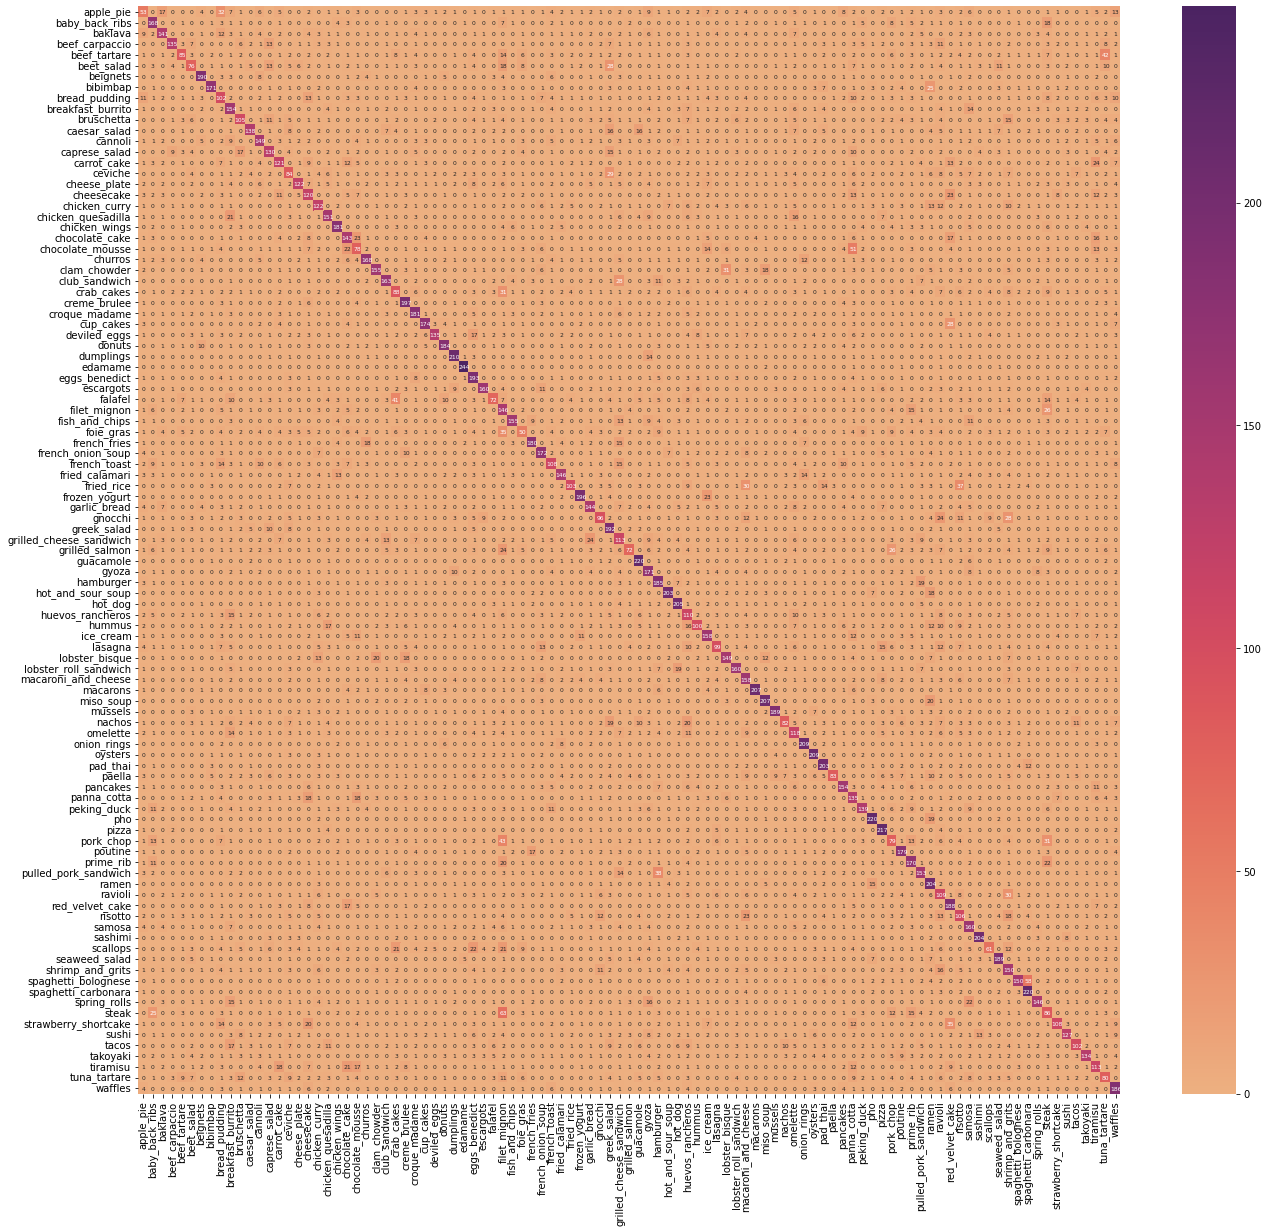

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

M = confusion_matrix(y_true=y_label, y_pred=pred_class)

plt.figure(figsize = (22,20))
sns.heatmap(M,annot = True, cmap = 'flare',fmt = 'd',
            xticklabels=train10.class_names, yticklabels = train10.class_names,annot_kws={"fontsize":6})
plt.show()

In [47]:
from sklearn.metrics import classification_report
classification_report(y_label, pred_class, output_dict=True)

{'0': {'f1-score': 0.25980392156862747,
  'precision': 0.33544303797468356,
  'recall': 0.212,
  'support': 250},
 '1': {'f1-score': 0.6165137614678899,
  'precision': 0.5694915254237288,
  'recall': 0.672,
  'support': 250},
 '10': {'f1-score': 0.4625550660792952,
  'precision': 0.5147058823529411,
  'recall': 0.42,
  'support': 250},
 '100': {'f1-score': 0.6231155778894473,
  'precision': 0.5360230547550432,
  'recall': 0.744,
  'support': 250},
 '11': {'f1-score': 0.6359447004608295,
  'precision': 0.75,
  'recall': 0.552,
  'support': 250},
 '12': {'f1-score': 0.6169772256728779,
  'precision': 0.6394849785407726,
  'recall': 0.596,
  'support': 250},
 '13': {'f1-score': 0.5383022774327122,
  'precision': 0.5579399141630901,
  'recall': 0.52,
  'support': 250},
 '14': {'f1-score': 0.5094736842105262,
  'precision': 0.5377777777777778,
  'recall': 0.484,
  'support': 250},
 '15': {'f1-score': 0.3566878980891719,
  'precision': 0.38009049773755654,
  'recall': 0.336,
  'support': 250

In [55]:
report = classification_report(y_label, pred_class, output_dict=True)
f1_scores = {}
class_names = train10.class_names
for k,v in report.items():
  if k == 'accuracy':
    break
  else:
    f1_scores[class_names[int(k)]] = v["f1-score"]

report = pd.DataFrame(index = f1_scores.keys(), data = f1_scores.values())
report.columns = ['f1 scores']
report.head()

,f1 scores
apple_pie,0.259804
baby_back_ribs,0.616514
baklava,0.603854
beef_carpaccio,0.652174
beef_tartare,0.429293


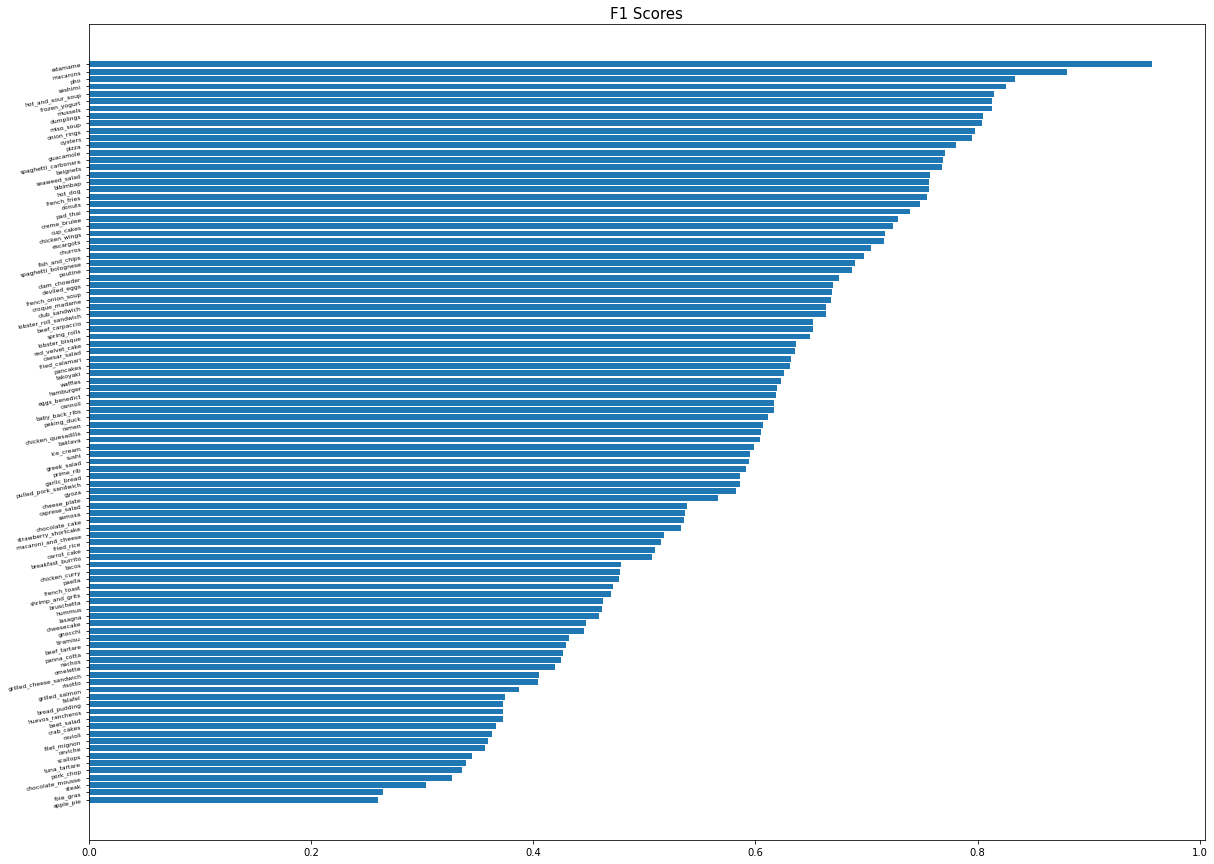

In [63]:
report = report.sort_values(by = 'f1 scores', ascending=True)
plt.figure(figsize=(20,15))
plt.barh(y = report.index,width = report['f1 scores'])
plt.yticks(rotation=10,fontsize = 6)
plt.title('F1 Scores',fontsize = 15)
plt.show()

In [ ]:
f1_scores = report.sort_values(by = 'f1 scores', ascending=True)

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## View prediction (images)

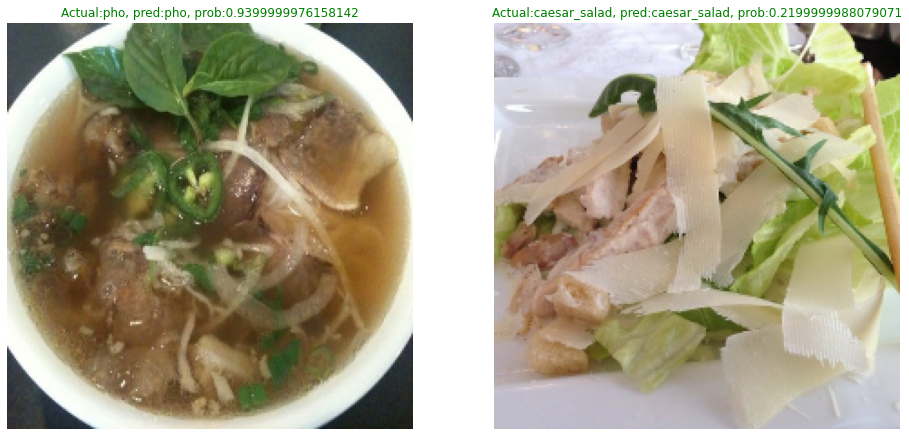

In [66]:
def load_image(filename,shape = 224,scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img) # decode into tensors
  img = tf.image.resize(img,[shape,shape])
  if scale:
    return img/255.
  else:
    return img



import os
import random

class_names = train10.class_names
plt.figure(figsize = (16,9))
for i in range(2):
  classname = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+'/'+classname))
  filepath = test_dir+classname+'/'+filename

  img = load_image(filepath,scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis = 0)) # add batch, so shape matches
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,2,i+1)
  plt.imshow(img/255) # need float
  if classname == pred_class:
    color = 'green'
  else:
    color = 'red'
  plt.title(f"Actual:{classname}, pred:{pred_class}, prob:{round(pred_prob.max(),2)}", color = color)
  plt.axis(False)


## Most wrong

In [86]:
import numpy as np
len(np.array([class_names[i] for i in pred_class]))

25250

In [97]:
filepath = []
for path in test.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                shuffle=False):
  filepath.append(path)

pred_prob = model.predict(test,verbose = 1)
pred_class = pred_prob.argmax(axis = 1)
df = pd.DataFrame({'path':filepath,
                   'ytrue':y_label,
                   'ypred':pred_class,
                   'confidence':pred_prob.max(axis = 1),
                   'true_class':[class_names[i] for i in y_label],
                   'pred_class':[class_names[i] for i in pred_class]
                   })
df = df.sort_values(by = 'confidence')
df.head()

,path,ytrue,ypred,confidence,true_class,pred_class
4012,tf.Tensor(b'101_food_classes_10_percent/test/c...,16,90,0.082714,cheese_plate,spaghetti_bolognese
12626,tf.Tensor(b'101_food_classes_10_percent/test/g...,50,82,0.089456,grilled_salmon,ravioli
15585,tf.Tensor(b'101_food_classes_10_percent/test/m...,62,25,0.093203,macaroni_and_cheese,club_sandwich
3057,tf.Tensor(b'101_food_classes_10_percent/test/c...,12,100,0.093762,cannoli,waffles
14235,tf.Tensor(b'101_food_classes_10_percent/test/h...,56,0,0.096422,huevos_rancheros,apple_pie


In [101]:
wrong = df[df.true_class != df.pred_class].nlargest(12,'confidence')
wrong

,path,ytrue,ypred,confidence,true_class,pred_class
23631,tf.Tensor(b'101_food_classes_10_percent/test/s...,94,83,0.999537,strawberry_shortcake,red_velvet_cake
23797,tf.Tensor(b'101_food_classes_10_percent/test/s...,95,86,0.998235,sushi,sashimi
21216,tf.Tensor(b'101_food_classes_10_percent/test/r...,84,70,0.997778,risotto,pad_thai
18001,tf.Tensor(b'101_food_classes_10_percent/test/p...,72,67,0.997136,pancakes,omelette
10880,tf.Tensor(b'101_food_classes_10_percent/test/f...,43,68,0.996594,fried_calamari,onion_rings
10854,tf.Tensor(b'101_food_classes_10_percent/test/f...,43,68,0.996397,fried_calamari,onion_rings
11041,tf.Tensor(b'101_food_classes_10_percent/test/f...,44,51,0.996008,fried_rice,guacamole
17816,tf.Tensor(b'101_food_classes_10_percent/test/p...,71,70,0.995641,paella,pad_thai
11642,tf.Tensor(b'101_food_classes_10_percent/test/g...,46,10,0.994711,garlic_bread,bruschetta
14255,tf.Tensor(b'101_food_classes_10_percent/test/h...,57,49,0.993887,hummus,grilled_cheese_sandwich


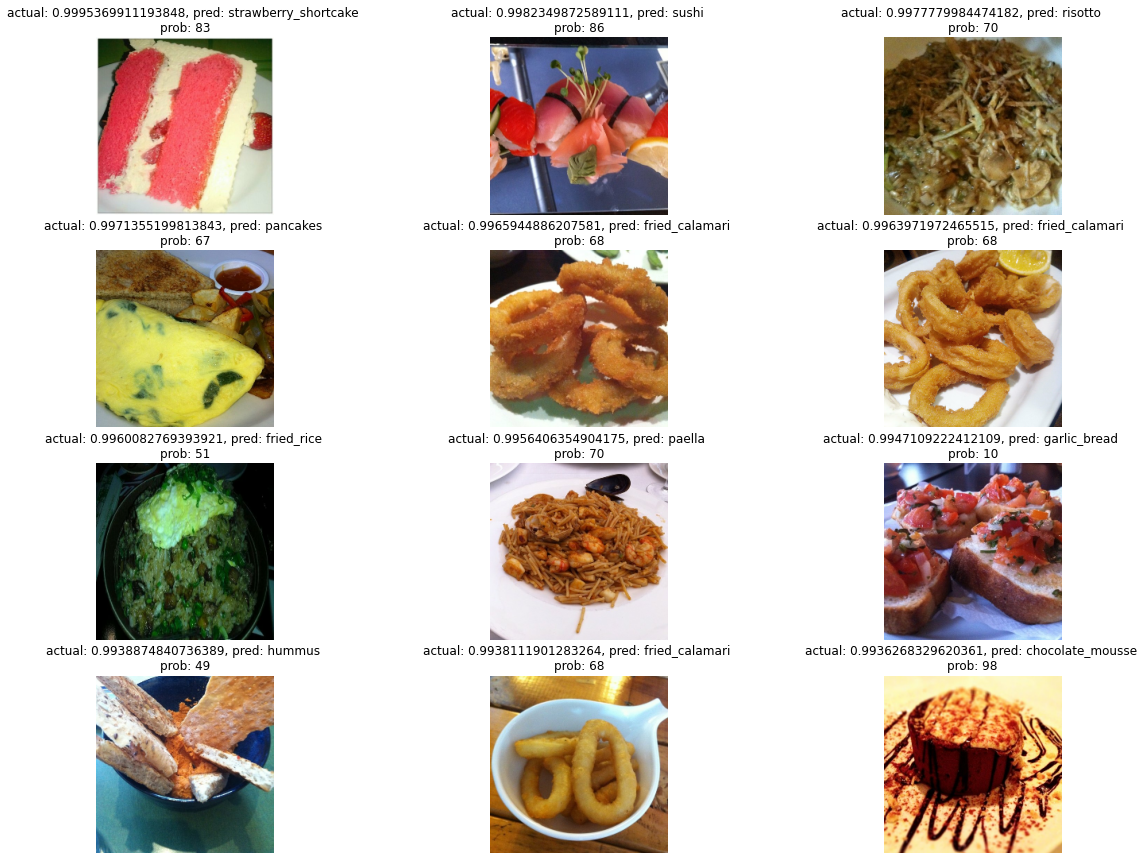

In [105]:
plt.figure(figsize = (20,15))
for i, row in enumerate(wrong.itertuples()):
  _, _, _, confidence, true_class, pred_class, _ = row # only need confidence, true_class, pred_class
  img = load_image(row[1], scale=True)
  
  plt.subplot(4, 3, i+1)
  plt.imshow(img)
  plt.title(f"actual: {true_class}, pred: {pred_class} \nprob: {round(confidence,2)}")
  plt.axis(False)

## Custom image

--2021-11-08 09:46:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 64.233.183.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  44.4MB/s    in 0.3s    

2021-11-08 09:46:01 (44.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



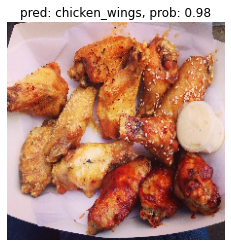

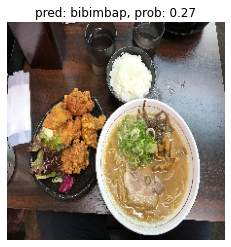

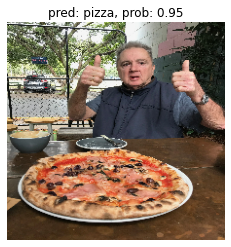

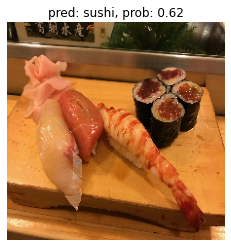

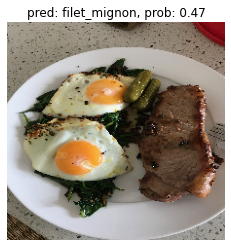

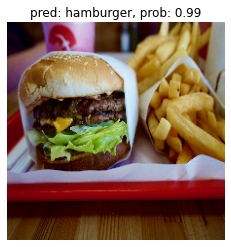

In [107]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

import zipfile
zip_ref = zipfile.ZipFile("custom_food_images.zip", "r")
zip_ref.extractall()
zip_ref.close()

images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]

for img in images:
  img = load_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # include batch, [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()]
  
  plt.figure()
  plt.imshow(img/255.) # need to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}") # alternative for round()
  plt.axis(False)